# Filter in time domain
Different approach. Take the 128 bin frequency domain response. Convert into time domain to get the filter `kernel`. Use as FIR filter coefficients.

In [1]:
%pylab notebook
from PIL import Image
import soundfile as sf
import pygame
from time import sleep

Populating the interactive namespace from numpy and matplotlib
pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


(128, 220)


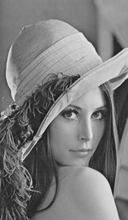

In [2]:
xOffs = 45
img = Image.open("./220px-Lenna_(test_image).png").convert("L")
img = img.crop([xOffs, 0, xOffs+128, img.size[1]])
print(img.size)
imgDat = asarray(img)
img

128


<IPython.core.display.Javascript object>


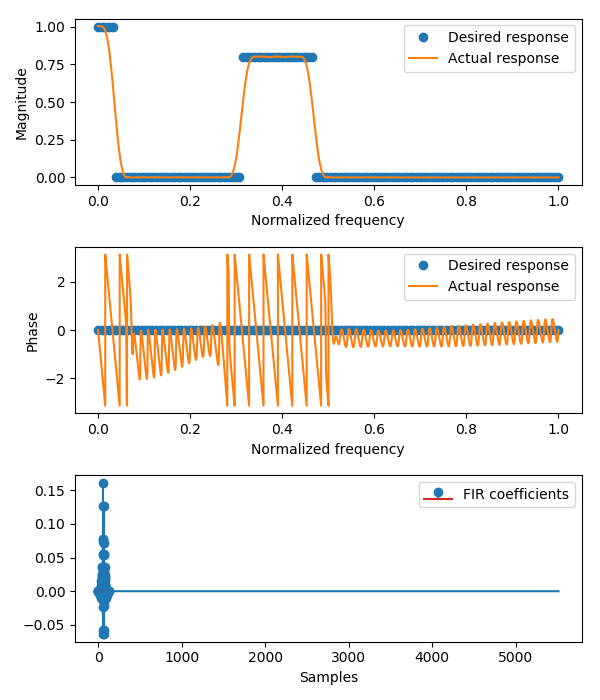

/home/michael/miniconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [90]:
# Get desired frequency response
h_f = zeros(128)
h_f[0:5] = 1
#h_f[20:22] = 1
h_f[40:60] = 0.8
#h_f = imgDat[30, :].astype("float")

# Calculate FIR coefficients
h_t = fft.irfft(h_f)
h_t = roll(h_t, h_t.size//2)

# Make filter faster by trunctation
trunc = 64
h_t = h_t[127-trunc:127+trunc]
print(h_t.size)

# Make filter smoother by windowing (stop band attenuation!!)
h_t *= hamming(h_t.size)

# Calculate actual response and plot
close("all")
fig, axs = subplots(3,1, figsize=(6,7))
h_ff = fft.rfft(h_t, 2**16)
axs[0].plot(linspace(0, 1, h_f.size), abs(h_f), "o", label="Desired response")
axs[0].plot(linspace(0, 1, h_ff.size), abs(h_ff), label="Actual response")
axs[0].set_xlabel("Normalized frequency")
axs[0].set_ylabel("Magnitude")
axs[1].plot(linspace(0, 1, h_f.size), angle(h_f), "o", label="Desired response")
axs[1].plot(linspace(0, 1, h_ff.size), angle(h_ff), label="Actual response")
axs[1].set_xlabel("Normalized frequency")
axs[1].set_ylabel("Phase")
axs[2].stem(h_t, label="FIR coefficients")
axs[2].set_xlabel("Samples")
for ax in axs:
    ax.legend(loc="upper right")
fig.tight_layout()

# Test with sound

In [66]:
aDat, sRate = sf.read("./AnchorsAweigh.ogg", always_2d=True)
aDat = mean(aDat, 1)
print(sRate, aDat.shape)

11025 (848262,)


In [69]:
pygame.mixer.pre_init(sRate, size=-16, channels=1)
pygame.mixer.init()

In [93]:
c.stop()

### Original

In [80]:
c = pygame.sndarray.make_sound((aDat * (2**15)).astype(int16)).play()

### Filtered

In [92]:
aRes = convolve(aDat, h_t)
c = pygame.sndarray.make_sound((aRes * (2**15)).astype(int16)).play()

In [94]:
from scipy.signal import welch

<IPython.core.display.Javascript object>


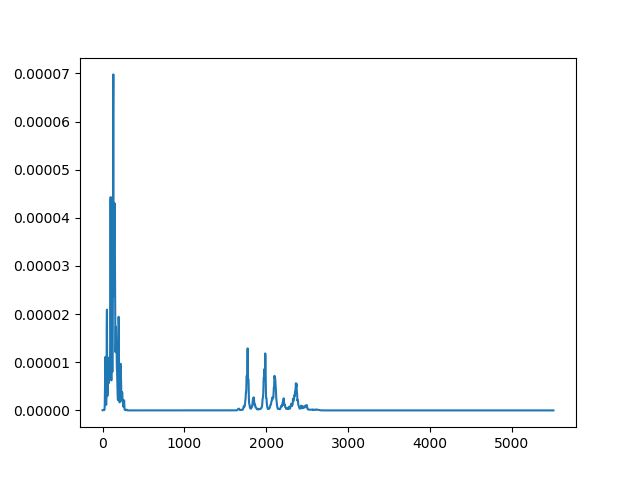

In [99]:
close("all")
plot( *welch(aRes, sRate, nperseg=4096) )